Data loaded successfully with shape: (360, 65)
Strong correlations saved to C:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\Data\strong_correlations_per_industry.csv
Correlation DataFrame for Q Gezondheids- en welzijnszorg:
                                    Feature  Correlation
0                Ziekteverzuimpercentage_1     1.000000
1              k_20Tot50WerkzamePersonen_7     0.771100
2                      OverigOfOnbekend_32     0.756173
3   ArbeidsvolumeZonderSeizoenscorrectie_4     0.743850
4      ArbeidsvolumeMetSeizoenscorrectie_3     0.737323
5                       PrijsindexArbeid_1     0.720267
6             k_10Tot50WerkzamePersonen_19     0.703893
7                CooperatieveVereniging_29     0.699684
8             MaandloonInclusiefOverwerk_5     0.697581
9             MaandloonExclusiefOverwerk_6     0.696128
10          BanenZonderSeizoenscorrectie_2     0.689332
11                 TotaalRechtspersonen_26     0.688009
12              

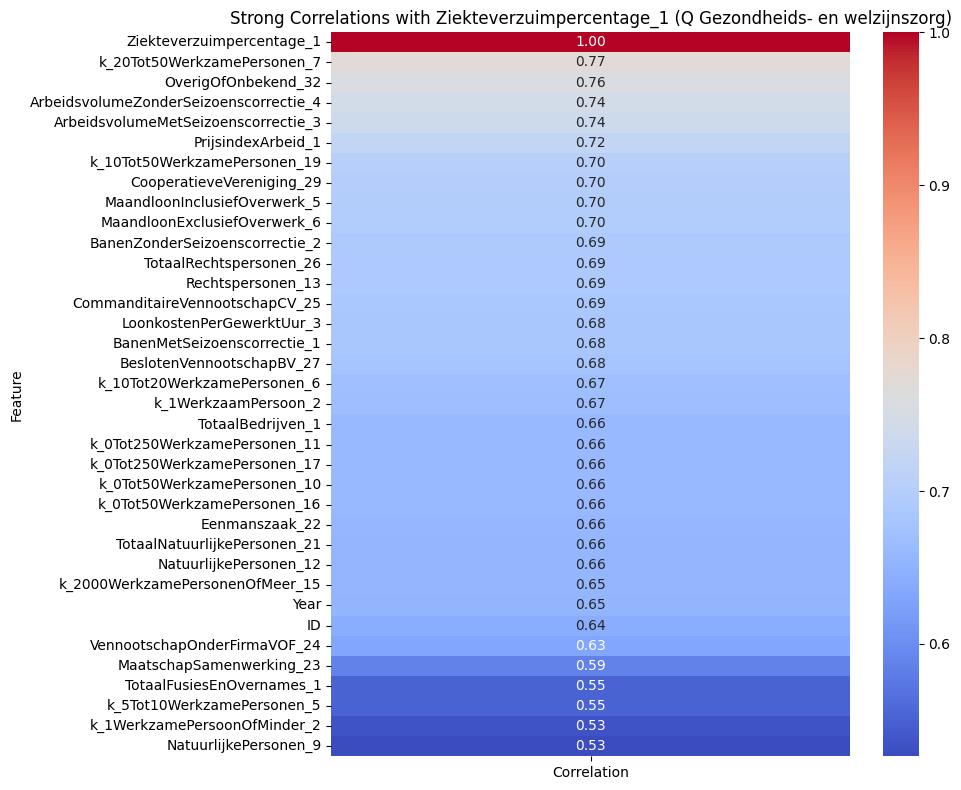

Correlation DataFrame for G Handel:
                                    Feature  Correlation
0                Ziekteverzuimpercentage_1     1.000000
1      ArbeidsvolumeMetSeizoenscorrectie_3     0.851490
2                           Eenmanszaak_22     0.846241
3             TotaalNatuurlijkePersonen_21     0.839792
4                   NatuurlijkePersonen_12     0.839792
5                     k_1WerkzaamPersoon_2     0.837051
6                        TotaalBedrijven_1     0.836037
7             k_0Tot250WerkzamePersonen_17     0.836016
8             k_0Tot250WerkzamePersonen_11     0.836016
9              k_0Tot50WerkzamePersonen_10     0.835472
10             k_0Tot50WerkzamePersonen_16     0.835472
11                       Rechtspersonen_13     0.812443
12                 TotaalRechtspersonen_26     0.812443
13             BanenMetSeizoenscorrectie_1     0.808925
14           k_50Tot250WerkzamePersonen_20     0.803183
15                     OverigOfOnbekend_32     0.801473
16  Arbeids

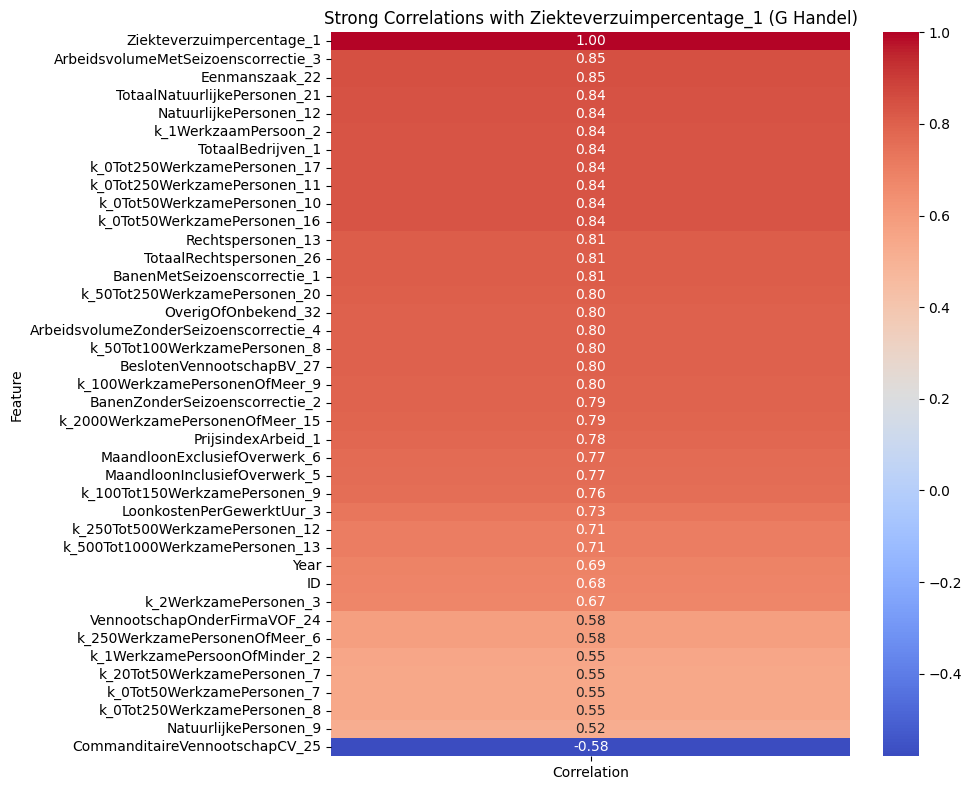

Correlation DataFrame for C Industrie:
                              Feature  Correlation
0          Ziekteverzuimpercentage_1     1.000000
1                  Rechtspersonen_13     0.710406
2            TotaalRechtspersonen_26     0.710406
3          BeslotenVennootschapBV_27     0.701034
4                OverigOfOnbekend_32     0.667868
5        k_2Tot10WerkzamePersonen_18     0.653601
6              k_2WerkzamePersonen_3     0.650937
7                  TotaalBedrijven_1     0.642751
8       k_0Tot250WerkzamePersonen_17     0.641714
9       k_0Tot250WerkzamePersonen_11     0.641714
10       k_0Tot50WerkzamePersonen_10     0.640196
11       k_0Tot50WerkzamePersonen_16     0.640196
12    k_200Tot250WerkzamePersonen_11     0.622262
13            NatuurlijkePersonen_12     0.621576
14      TotaalNatuurlijkePersonen_21     0.621576
15              k_1WerkzaamPersoon_2     0.619971
16                    Eenmanszaak_22     0.619611
17          VerenigingOfStichting_30     0.614810
18        

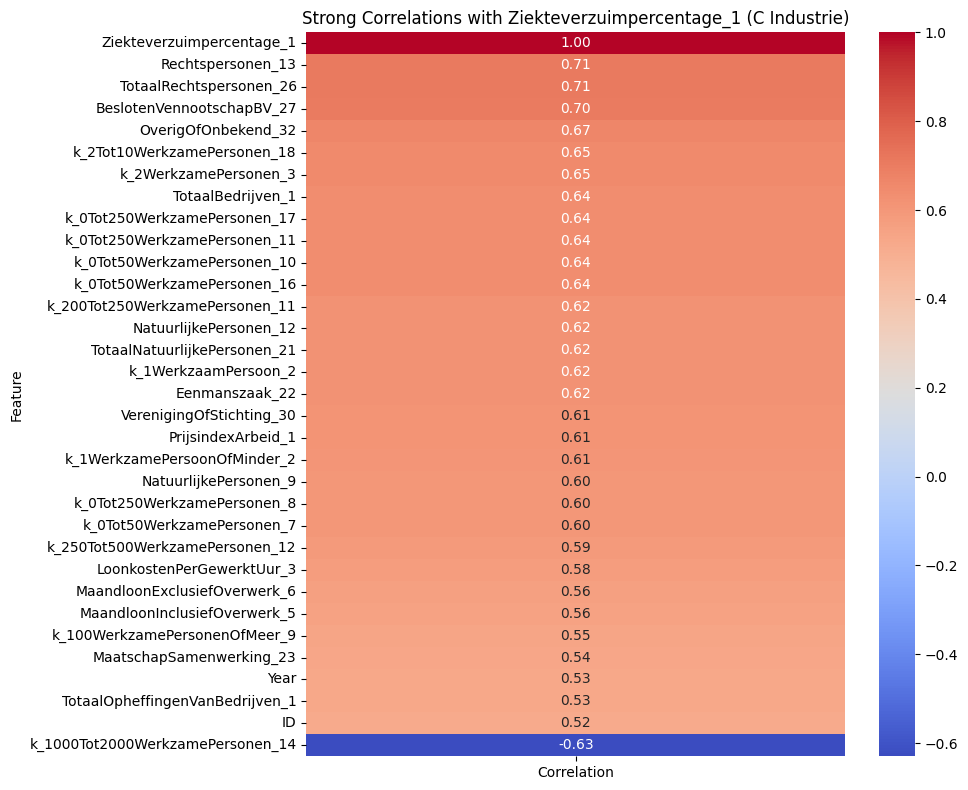

In [24]:
# %% [markdown]
# ## Importing Libraries

# %%
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cbsodata
import requests
import re
from concurrent.futures import ThreadPoolExecutor

# %% [markdown]
# ## Configuration

# %%
DATA_DIR = r"C:\Users\c.hakker\OneDrive - VISTA college\Senior Stuff\Opleiding Data science\Data"

# Ensure the data directory exists
os.makedirs(DATA_DIR, exist_ok=True)

# File paths
SBI_DATA_FILE = os.path.join(DATA_DIR, 'sbi_data.json')
TABLE_SELECTION_FILE = os.path.join(DATA_DIR, 'table_selection.json')
UNIQUE_DATA_FILE = os.path.join(DATA_DIR, 'unique_data.json')
MERGED_TABLES_FILE = os.path.join(DATA_DIR, 'merged_tables.csv')
OUTPUT_CORRELATIONS_FILE = os.path.join(DATA_DIR, 'strong_correlations_per_industry.csv')

# Desired SBI titles
DESIRED_SBI_TITLE = [
    "Q Gezondheids- en welzijnszorg", "G Handel", "C Industrie",
    "M Specialistische zakelijke diensten", "N Verhuur en overige zakelijke diensten",
    "O Openbaar bestuur en overheidsdiensten"
]

# Desired frequencies
DESIRED_FREQUENCIES = [
    "Fourtimesayear", "Viermaalperjaar", "Quarterly", "Perkwartaal", 
    "Threemonthly", "Perdriemaanden", "Monthly", "Permaand"
]

# Excluded identifiers
EXCLUDED_IDENTIFIERS = ['85663NED']

# Criteria
DESIRED_LANGUAGE = 'nl'
START_YEAR_THRESHOLD = 2008
END_YEAR_THRESHOLD = 2022

# %% [markdown]
# ## Helper Functions

# %%
def load_json(file_path):
    """Loads a JSON file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return json.load(file)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Error loading JSON file {file_path}: {e}")
        return None

def save_json(data, file_path):
    """Saves data to a JSON file."""
    try:
        with open(file_path, 'w', encoding='utf-8') as file:
            json.dump(data, file, indent=4, ensure_ascii=False)
        print(f"Data saved to {file_path}")
    except Exception as e:
        print(f"Error saving JSON file {file_path}: {e}")

def extract_years(period):
    """Extracts the first and last year from a period string."""
    years = re.findall(r'\b\d{4}\b', period)
    if len(years) >= 2:
        return int(years[0]), int(years[-1])
    elif len(years) == 1:
        return int(years[0]), int(years[0])
    return None, None

def fetch_sbi_code(identifier):
    """Fetches SBI code information for a given identifier."""
    urls = [
        f"https://opendata.cbs.nl/ODataApi/OData/{identifier}/BedrijfstakkenBranchesSBI2008",
        f"https://opendata.cbs.nl/ODataApi/OData/{identifier}/BedrijfskenmerkenSBI2008"
    ]
    for url in urls:
        try:
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json()
                return identifier, data.get('value', [])
        except Exception as e:
            print(f"Error fetching SBI data for {identifier}: {e}")
    return identifier, "Failed to fetch SBI data"

def process_correlations(df, industries, target_col='Ziekteverzuimpercentage_1', threshold=0.5):
    """Processes correlations for specified industries."""
    results = {}
    for industry in industries:
        industry_data = df[df['BedrijfstakkenBranchesSBI2008'] == industry]
        numeric_data = industry_data.select_dtypes(include=[float, int])
        if target_col not in numeric_data.columns:
            print(f"Target column {target_col} not found for industry: {industry}")
            continue
        correlations = numeric_data.corr()[target_col]
        strong_corr = correlations[abs(correlations) > threshold].sort_values(ascending=False)
        results[industry] = strong_corr
    return results

def plot_and_save_heatmaps(correlations, output_dir):
    """
    Plots and saves heatmaps for correlation data.
    Parameters:
        correlations (dict): A dictionary where keys are industry names and values are correlation Series.
        output_dir (str): Directory to save the heatmaps.
    """
    for industry, corr_data in correlations.items():
        if corr_data.empty:
            print(f"No strong correlations for {industry}.")
            continue
        
        # Convert correlation Series to DataFrame for heatmap
        correlation_df = corr_data.to_frame(name='Correlation').reset_index()
        correlation_df.columns = ['Feature', 'Correlation']
        
        # Debug print for checking correlation DataFrame
        print(f"Correlation DataFrame for {industry}:\n", correlation_df)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_df.set_index('Feature'), annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
        plt.title(f"Strong Correlations with Ziekteverzuimpercentage_1 ({industry})")
        plt.tight_layout()
        
        # Save heatmap
        heatmap_path = os.path.join(output_dir, f"correlation_heatmap_{industry.replace(' ', '_')}.png")
        plt.savefig(heatmap_path)
        print(f"Heatmap saved to {heatmap_path}")
        
        # Display the heatmap
        plt.show()

# %% [markdown]
# ## Load and Process Data

# %%
# Load merged tables
try:
    df = pd.read_csv(MERGED_TABLES_FILE)
    print(f"Data loaded successfully with shape: {df.shape}")
except FileNotFoundError:
    print(f"File not found: {MERGED_TABLES_FILE}. Exiting.")
    exit()

if 'Ziekteverzuimpercentage_1' not in df.columns:
    print(f"Target column 'Ziekteverzuimpercentage_1' not in dataset. Exiting.")
    exit()

# Industries of interest
industries_of_interest = ["Q Gezondheids- en welzijnszorg", "G Handel", "C Industrie"]

# Process correlations
correlation_results = process_correlations(df, industries_of_interest)

# Save correlations to CSV
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index').transpose()
correlation_df.to_csv(OUTPUT_CORRELATIONS_FILE, index=True)
print(f"Strong correlations saved to {OUTPUT_CORRELATIONS_FILE}")

# Generate heatmaps
plot_and_save_heatmaps(correlation_results, DATA_DIR)
